# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Fri Mar 24 22:29:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [5]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [6]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ), Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [7]:
BATCH_SIZE = 8
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

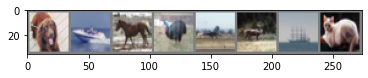

dog   ship  horse bird  plane deer  ship  cat  


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


## Model

In [9]:
# Parameters 


N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [10]:
class ConvBlock(nn.Sequential):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL):
        
        super(ConvBlock, self).__init__(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            #nn.Dropout2d(p=0.1),
        )

In [11]:
class Backbone(nn.Module):

  def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
    super(Backbone, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug

    self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    
    self.linear = nn.Sequential(
        nn.Linear(in_features=in_channels, out_features=k, bias=False),   # Question, can this be MLP?
        #nn.Tanh(),
        # nn.LeakyReLU(),
        # nn.Linear(in_features=k, out_features=k, bias=True),  
        # nn.ReLU(),
        nn.Sigmoid(),      # Non Linear Activation
    )

    self.conv_blocks = nn.ModuleList([
        ConvBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        for _ in range(k)
    ])
    
    self.batch_norm = nn.BatchNorm2d(num_features=out_channels)

  def forward(self, x):
    sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"{sap_out.shape=}")

    g_out = self.linear(sap_out)
    if self.debug: print(f"{g_out.shape=}")
    if self.debug: print(f"{g_out=}")

    outs = list()
    for a, conv_block in zip(g_out.transpose(0, 1), self.conv_blocks):
    #for conv2d in self.conv2ds:
      c_out = conv_block(x)
      if self.debug: print(f"{c_out.shape=}")
      if self.debug: print(f"{a.shape=}, \n{a=}")

      out = a.reshape(x.shape[0], 1, 1, 1)*c_out
      if self.debug: print(f"{out.shape=}")
      outs.append(out)
      #outs.append(c_out)
      
    out = sum(outs)
    if self.debug: print(f"{out.shape=}")
    
    out = self.batch_norm(out)
    if self.debug: print(f"{batch_out.shape=}")

    return out

In [12]:
class Model(nn.Module):
    
    def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
        super(Model, self).__init__()

        # Boolean to print debug logs.
        self.debug = debug
        self.Ks = Ks
        self.channels = channels
        self.n = n

        if self.debug: print(f"{self.channels=}")
        if self.debug: print(f"{self.Ks=}")
        if self.debug: print(f"{n=}")

        self.backbones = nn.ModuleList([
            Backbone(
                in_channels=self.channels[i], 
                out_channels=self.channels[i+1], 
                kernel_size=kernel_size, 
                k=self.Ks[i], 
                debug=debug
            ) 
            for i in range(n)
        ])

        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Sequential(
            # nn.Linear(in_features=self.channels[-1], out_features=self.channels[-1] * 2 // 3, bias=False),
            # nn.Dropout(p=0.2),
            # nn.ReLU(),
            # nn.Linear(in_features=self.channels[-1] * 2 // 3, out_features=self.channels[-1] // 3, bias=False),
            # nn.Dropout(p=0.2),
            # nn.ReLU(),
            # nn.Linear(in_features=self.channels[-1] // 3, out_features=len(CLASSES), bias=False),
            nn.Linear(in_features=self.channels[-1], out_features=len(CLASSES), bias=False),
        )
        # self.linear = nn.Linear(in_features=self.channels[-1], out_features=len(CLASSES), bias=False)

    def set_debug(self, debug=True):
        self.debug = debug
        for backbone in self.backbones:
            backbone.debug = debug

    def forward(self, x):
        for backbone in self.backbones:
            x = backbone(x)
    
        f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"M: {f.shape=}")

        out = self.linear(f)
        if self.debug: print(f"M: {out.shape=}")

        return out

In [13]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, epochs, trainloader, testloader, logs_per_epoch=4) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.log_step = len(trainloader) // logs_per_epoch

        self.trainloader = trainloader
        self.testloader = testloader

        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
        
    
    def train(self, use_gpu=False):
        
        correct = 0
        total = 0
        
        for epoch in range(self.epochs):  # loop over the dataset multiple times

            batch_losses = list()
            running_loss = 0.0
            for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} "):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            print(f"Train Loss : {self.losses[-1]}")
            
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            print(f'Train Accuracy : {100 * accuracy:.2f} %')
            
            self.eval()

        print('Finished Training')
    
    
    def eval(self):
        correct = 0
        total = 0
        losses = list()
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)

        print(f"Val Loss : {val_loss}")

        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
    
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(10, 3)

        X = np.linspace(0, len(self.losses)-1, len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
        
        ax2.plot(self.train_accuracy, label="Train", color='C0', lw=3, alpha=1)
        ax2.plot(self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        plt.tight_layout()
        fig.show()
    

In [14]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [15]:
def model_summary(model, trainloader):

    img_sizes = list()
    
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            if USE_GPU:
                images = images.to('cuda')
                labels = labels.to('cuda')
            
            x = images
            
            img_sizes.append(x.shape[-1])
            for backbone in model.backbones:
                x = backbone(x)
                img_sizes.append(x.shape[-1])
            break
                
    print(f"{model.channels=}")
    print(f"{model.Ks=}")
    print(f"{model.n=}")
    print(f"{img_sizes=}")


## Experiment

In [16]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
channels = [IMG_CHANNELS, 64, 128, 256, 512] #19, ]
# Ks = channels[1:]
Ks = [3] * (len(channels) - 1)
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)
if USE_GPU: model.to('cuda')
model.set_debug(False)

model

self.channels=[3, 64, 128, 256, 512]
self.Ks=[3, 3, 3, 3]
n=4


Model(
  (backbones): ModuleList(
    (0): Backbone(
      (spaitial_average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=False)
        (1): Sigmoid()
      )
      (conv_blocks): ModuleList(
        (0): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(

In [17]:
model_summary(model=model, trainloader=trainloader)

model.channels=[3, 64, 128, 256, 512]
model.Ks=[3, 3, 3, 3]
model.n=4
img_sizes=[32, 16, 8, 4, 2]


In [18]:
# Init optimizer 

LR = 1e-3 #1e-3, 1e-4
MOMENTUM = 0.9 #0.9


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.15)

In [19]:
# Init Trainer

EPOCHS = 3
BATCH_SIZE = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=EPOCHS, 
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

Epoch 1 :   0%|          | 0/391 [00:00<?, ?it/s]

[1,    97] loss: 1.786
[1,   194] loss: 1.338
[1,   291] loss: 1.189
[1,   388] loss: 1.071
Train Loss : 1.3432160571712972
Train Accuracy : 52.57 %
Val Loss : 1.0140111446380615
Accuracy of the network on the 10000 test images: 64.10 %


Epoch 2 :   0%|          | 0/391 [00:00<?, ?it/s]

[2,    97] loss: 0.903
[2,   194] loss: 0.859
[2,   291] loss: 0.802
[2,   388] loss: 0.759
Train Loss : 0.8295889181249282
Train Accuracy : 61.77 %
Val Loss : 0.7470042539548271
Accuracy of the network on the 10000 test images: 74.09 %


Epoch 3 :   0%|          | 0/391 [00:00<?, ?it/s]

[3,    97] loss: 0.614
[3,   194] loss: 0.625
[3,   291] loss: 0.602
[3,   388] loss: 0.584
Train Loss : 0.6063497535255559
Train Accuracy : 67.46 %
Val Loss : 0.6378178604041473
Accuracy of the network on the 10000 test images: 77.91 %
Finished Training


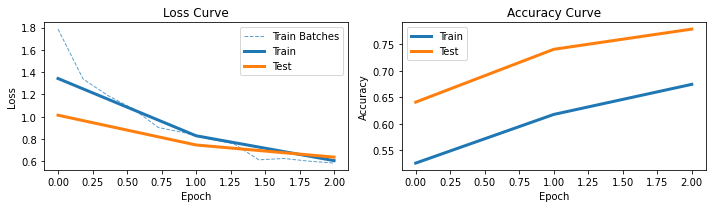

In [20]:
trainer.epochs = 3

trainer.train(use_gpu=USE_GPU)
trainer.plot()

Epoch 1 :   0%|          | 0/391 [00:00<?, ?it/s]

[1,    97] loss: 0.461
[1,   194] loss: 0.460
[1,   291] loss: 0.490
[1,   388] loss: 0.452
Train Loss : 0.466474759990297
Train Accuracy : 83.76 %
Val Loss : 0.6570074354545979
Accuracy of the network on the 10000 test images: 78.25 %


Epoch 2 :   0%|          | 0/391 [00:00<?, ?it/s]

[2,    97] loss: 0.331
[2,   194] loss: 0.361
[2,   291] loss: 0.363
[2,   388] loss: 0.366
Train Loss : 0.3556829145573594
Train Accuracy : 85.73 %
Val Loss : 0.5715496917314167
Accuracy of the network on the 10000 test images: 81.07 %


Epoch 3 :   0%|          | 0/391 [00:00<?, ?it/s]

[3,    97] loss: 0.231
[3,   194] loss: 0.247
[3,   291] loss: 0.296
[3,   388] loss: 0.291
Train Loss : 0.26722003431881175
Train Accuracy : 87.47 %
Val Loss : 0.5766438785233076
Accuracy of the network on the 10000 test images: 81.43 %


Epoch 4 :   0%|          | 0/391 [00:00<?, ?it/s]

[4,    97] loss: 0.160
[4,   194] loss: 0.174
[4,   291] loss: 0.192
[4,   388] loss: 0.208
Train Loss : 0.18436272975886264
Train Accuracy : 89.08 %
Val Loss : 0.6200672376759445
Accuracy of the network on the 10000 test images: 80.65 %


Epoch 5 :   0%|          | 0/391 [00:00<?, ?it/s]

[5,    97] loss: 0.110
[5,   194] loss: 0.103
[5,   291] loss: 0.142
[5,   388] loss: 0.165
Train Loss : 0.1302662400142921
Train Accuracy : 90.45 %
Val Loss : 0.6048399817339981
Accuracy of the network on the 10000 test images: 81.71 %


Epoch 6 :   0%|          | 0/391 [00:00<?, ?it/s]

[6,    97] loss: 0.093
[6,   194] loss: 0.093
[6,   291] loss: 0.117
[6,   388] loss: 0.127
Train Loss : 0.1079349204745439
Train Accuracy : 91.46 %
Val Loss : 0.6213977438739583
Accuracy of the network on the 10000 test images: 82.21 %


Epoch 7 :   0%|          | 0/391 [00:00<?, ?it/s]

[7,    97] loss: 0.072
[7,   194] loss: 0.065
[7,   291] loss: 0.075
[7,   388] loss: 0.112
Train Loss : 0.08155542052805881
Train Accuracy : 92.32 %
Val Loss : 0.6392006708096855
Accuracy of the network on the 10000 test images: 82.09 %


Epoch 8 :   0%|          | 0/391 [00:00<?, ?it/s]

[8,    97] loss: 0.063
[8,   194] loss: 0.080
[8,   291] loss: 0.100
[8,   388] loss: 0.105
Train Loss : 0.0868877841497931
Train Accuracy : 92.93 %
Val Loss : 0.6437388907504987
Accuracy of the network on the 10000 test images: 82.22 %


Epoch 9 :   0%|          | 0/391 [00:00<?, ?it/s]

[9,    97] loss: 0.066
[9,   194] loss: 0.055
[9,   291] loss: 0.079
[9,   388] loss: 0.098
Train Loss : 0.07542558579855715
Train Accuracy : 93.44 %
Val Loss : 0.6718637030335921
Accuracy of the network on the 10000 test images: 81.62 %


Epoch 10 :   0%|          | 0/391 [00:00<?, ?it/s]

[10,    97] loss: 0.056
[10,   194] loss: 0.049
[10,   291] loss: 0.052
[10,   388] loss: 0.069
Train Loss : 0.05706569699861128
Train Accuracy : 93.93 %
Val Loss : 0.6713683763636819
Accuracy of the network on the 10000 test images: 82.30 %


Epoch 11 :   0%|          | 0/391 [00:00<?, ?it/s]

[11,    97] loss: 0.055
[11,   194] loss: 0.056
[11,   291] loss: 0.069
[11,   388] loss: 0.102
Train Loss : 0.07065015671598485
Train Accuracy : 94.27 %
Val Loss : 0.671177296698848
Accuracy of the network on the 10000 test images: 81.80 %


Epoch 12 :   0%|          | 0/391 [00:00<?, ?it/s]

[12,    97] loss: 0.050
[12,   194] loss: 0.041
[12,   291] loss: 0.060
[12,   388] loss: 0.074
Train Loss : 0.056287590909720686
Train Accuracy : 94.59 %
Val Loss : 0.6776887280277059
Accuracy of the network on the 10000 test images: 82.08 %


Epoch 13 :   0%|          | 0/391 [00:00<?, ?it/s]

[13,    97] loss: 0.046
[13,   194] loss: 0.033
[13,   291] loss: 0.047
[13,   388] loss: 0.080
Train Loss : 0.05193982191641084
Train Accuracy : 94.88 %
Val Loss : 0.7052960067610198
Accuracy of the network on the 10000 test images: 81.30 %


Epoch 14 :   0%|          | 0/391 [00:00<?, ?it/s]

[14,    97] loss: 0.067
[14,   194] loss: 0.053
[14,   291] loss: 0.068
[14,   388] loss: 0.073
Train Loss : 0.0652258870098978
Train Accuracy : 95.10 %
Val Loss : 0.6619130146654346
Accuracy of the network on the 10000 test images: 82.84 %


Epoch 15 :   0%|          | 0/391 [00:00<?, ?it/s]

[15,    97] loss: 0.042
[15,   194] loss: 0.034
[15,   291] loss: 0.041
[15,   388] loss: 0.048
Train Loss : 0.0416221755254261
Train Accuracy : 95.34 %
Val Loss : 0.678192132258717
Accuracy of the network on the 10000 test images: 82.05 %


Epoch 16 :   0%|          | 0/391 [00:00<?, ?it/s]

[16,    97] loss: 0.053
[16,   194] loss: 0.046
[16,   291] loss: 0.049
[16,   388] loss: 0.069
Train Loss : 0.05429535691180955
Train Accuracy : 95.52 %
Val Loss : 0.6792697876314574
Accuracy of the network on the 10000 test images: 82.37 %


Epoch 17 :   0%|          | 0/391 [00:00<?, ?it/s]

[17,    97] loss: 0.044
[17,   194] loss: 0.045
[17,   291] loss: 0.054
[17,   388] loss: 0.062
Train Loss : 0.05103574789193509
Train Accuracy : 95.68 %
Val Loss : 0.6561156251007998
Accuracy of the network on the 10000 test images: 83.15 %
Finished Training


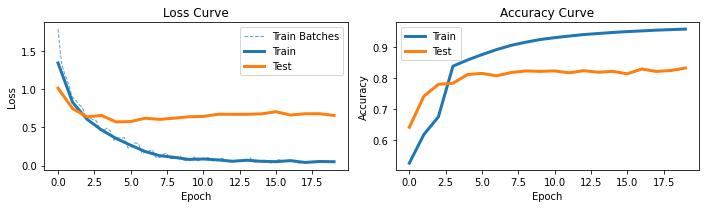

In [21]:
trainer.epochs = 17

trainer.train(use_gpu=USE_GPU)
trainer.plot()

In [ ]:
trainer.epochs = 17

trainer.train(use_gpu=USE_GPU)
trainer.plot()

Epoch 1 :   0%|          | 0/782 [00:00<?, ?it/s]

[1,   195] loss: 0.840
[1,   390] loss: 0.790
[1,   585] loss: 0.780
[1,   780] loss: 0.757
Train Loss : 0.7912311061187778
Train Accuracy : 72.59 %
Val Loss : 0.748308586466844
Accuracy of the network on the 10000 test images: 73.69 %


Epoch 2 :   0%|          | 0/782 [00:00<?, ?it/s]

[2,   195] loss: 0.703
[2,   390] loss: 0.680
[2,   585] loss: 0.675
[2,   780] loss: 0.688
Train Loss : 0.6864278028764383
Train Accuracy : 74.39 %
Val Loss : 0.7100853749141571
Accuracy of the network on the 10000 test images: 75.57 %


Epoch 3 :   0%|          | 0/782 [00:00<?, ?it/s]

[3,   195] loss: 0.602
[3,   390] loss: 0.622
[3,   585] loss: 0.612



KeyboardInterrupt



## Experiment

In [ ]:
class Model2(nn.Module):

  def __init__(self, channels, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model2, self).__init__()
	
    self.debug=debug
    
    self.convs = nn.ModuleList(
        nn.Sequential(
            nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size),
            #nn.BatchNorm2d(num_features=channels[i+1]),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
        )
        for i in range(n)
    )
    self.img_sizes = find_img_size(initial_img_size=IMG_DIM, depth=n+1, kernel_size=kernel_size, stride=1, pool=2)
    print(f"{self.img_sizes=}")
    
    #self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.linear = nn.Sequential(
        nn.Linear(in_features=channels[-1], out_features=len(CLASSES), bias=False),
    )

  def set_debug(self, debug=True):
    self.debug = debug

  def forward(self, x):

    #x = self.conv1(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv2(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv3(x)
    #if self.debug: print(f"M: {x.shape=}")
    
    for conv in self.convs:
        x = conv(x)
        if self.debug: print(f"M conv: {x.shape=}")
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out